# **Task: Bayesian approach to linear fitting**

This notebook compares different approaches to linear regression for datapoints with errors in **both axes**. The problem is demonstated using the below shown dataset $-$ correlation between Bondi accretion power $P_{\text{Bondi}}$ and mechanical power of relativistic jets $P_{\text{jet}}$ which was obtained as a part of my diploma thesis. The individual data points are differentiated by the presence the of H$\alpha$ emission to: nuclear emission (NE), extended emission (E) and no emission (N).

The task is to "fit" a subgroup (extended + nuclear H$\alpha$ emission) of datapoints using various fitting techniques:
- [LINMIX](https://github.com/jmeyers314/linmix) (Bayesian approach to linear regression)
- [PYMC3](https://docs.pymc.io/) based approach (written by myself so probably not correct, use LINMIX for Bayesian regression)
- [ODR](https://docs.scipy.org/doc/scipy/reference/odr.html) - Orthogonal distance regression (classical regression but using errors in both axes)
- [BCES](https://github.com/rsnemmen/BCES) - Bivariate Correlated Errors and intrinsic Scatter

In [ ]:
# requirements
# pip install numpy
# pip install pandas
# pip install matplotlib
# !git clone https://github.com/jmeyers314/linmix.git
# !python linmix/setup.py install
# pip install pymc3
# pip install scipy
# pip install bces
# pip install nmmn

## **Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.transforms as transforms
from scipy.stats import norm

plt.rc("lines", linewidth=0, marker="s", markersize=5.5)
plt.rc("errorbar", capsize=3)
plt.rc('xtick', direction='in', top=True)
plt.rc('ytick', direction='in', right=True)
plt.rc('axes', linewidth=1.25)

size = 15
plt.rc("mathtext", fontset="dejavuserif")
plt.rc('font', family='DejaVu Serif', size=size)

def histogram(array, bins, norm=False):
    h = np.histogram(array, bins = bins)
    x = (h[1][1:]+h[1][:-1])/2
    if norm: return x, x[1]-x[0], h[0] / sum(h[0])
    else: return x, x[1]-x[0], h[0]

## **Data import**

In [2]:
data = pd.read_csv("correlation.txt", index_col=0)

c = 1e43
x, xp, xm = data["Pjet"], data["Pjet+"], data["Pjet-"]
y, yp, ym = data["PBondi"], data["PBondi+"], data["PBondi-"]
x, xp, xm = x / c, xp / c, xm / c
y, yp, ym = y / c, yp / c, ym / c
ye = np.array([yp, ym]).mean(0); xe = np.array([xp, xm]).mean(0)
Halfa = data["Halfa"]

data

PBondi       PBondi+       PBondi-          Pjet         Pjet+  \
Galaxy                                                                          
IC4296   2.900000e+44  2.210000e+44  1.280000e+44  4.330000e+43  3.600000e+43   
NGC507   3.560000e+44  3.070000e+44  1.670000e+44  8.030000e+43  5.850000e+43   
NGC708   3.200000e+42  2.190000e+42  1.310000e+42  8.930000e+41  6.510000e+41   
NGC1316  1.640000e+42  1.620000e+42  8.390000e+41  1.720000e+41  1.330000e+41   
NGC1399  5.330000e+43  6.480000e+43  4.130000e+43  3.360000e+41  2.440000e+41   
NGC1407  2.650000e+44  1.530000e+44  8.370000e+43  1.340000e+42  1.030000e+42   
NGC1600  2.290000e+45  9.590000e+44  7.820000e+44  4.440000e+42  3.980000e+42   
NGC4261  4.010000e+44  2.510000e+44  1.260000e+44  1.960000e+43  1.480000e+43   
NGC4374  5.620000e+43  6.810000e+43  3.500000e+43  2.690000e+42  2.120000e+42   
NGC4472  2.510000e+44  1.620000e+44  5.550000e+43  4.980000e+41  3.550000e+41   
NGC4486  6.010000e+44  6.360000e+44  4.200000e+44  1.870000e+43  1.530000e+43   
NGC4552  2.880000e+43  1.840000e+43  1.220000e+43  9.610000e+41  7.280000e+41   
NGC4636  7.650000e+42  1.350000e+43  6.910000e+42  2.840000e+41  2.310000e+41   
NGC4649  4.070000e+44  2.610000e+44  1.850000e+44  2.240000e+41  1.870000e+41   
NGC4696  2.000000e+43  3.260000e+43  1.320000e+43  4.590000e+42  3.340000e+42   
NGC4778  2.330000e+43  1.790000e+43  1.020000e+43  8.350000e+41  6.250000e+41   
NGC5044  2.440000e+42  5.110000e+42  1.620000e+42  1.500000e+41  1.120000e+41   
NGC5813  1.660000e+43  1.620000e+43  7.930000e+42  7.150000e+41  5.460000e+41   
NGC5846  2.410000e+43  1.260000e+43  8.170000e+42  1.530000e+42  1.200000e+42   
NGC6166  3.790000e+43  4.380000e+43  2.040000e+43  9.500000e+42  7.220000e+42   

                Pjet- Halfa  
Galaxy                       
IC4296   1.830000e+43     E  
NGC507   2.830000e+43     N  
NGC708   3.130000e+41     E  
NGC1316  5.470000e+40     E  
NGC1399  1.220000e+41     N  
NGC1407  5.160000e+41     N  
NGC1600  2.140000e+42     N  
NGC4261  6.570000e+42    NE  
NGC4374  1.110000e+42    NE  
NGC4472  1.750000e+41     N  
NGC4486  8.280000e+42     E  
NGC4552  3.170000e+41     N  
NGC4636  1.140000e+41    NE  
NGC4649  1.040000e+41     N  
NGC4696  1.580000e+42     E  
NGC4778  3.140000e+41    NE  
NGC5044  4.950000e+40     E  
NGC5813  2.740000e+41     E  
NGC5846  5.750000e+41     E  
NGC6166  3.480000e+42     E

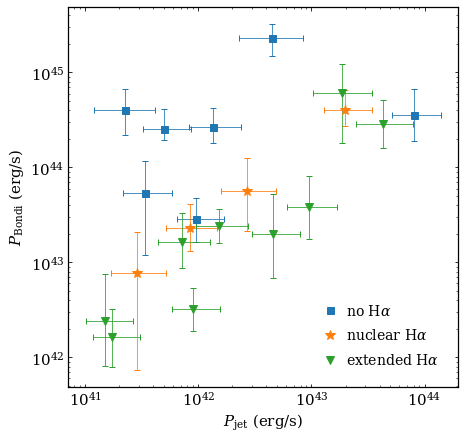

In [3]:
# Halfa emission
def plot_data():
    Ha = {"N" : ["C0", "s", 7],
          "NE" : ["C1", "*", 10],
          "E" : ["C2", "v", 8]}

    plt.figure(figsize=(7,7))
    
    for X, Xp, Xm, Y, Yp, Ym, ha, gal in zip(x, xp, xm, y, yp, ym, Halfa, data.index):
        kwargs = {"elinewidth" : 0.8,
                  "markersize" : Ha[ha][2],
                  "marker" : Ha[ha][1],
                  "color" : Ha[ha][0]}
        plt.errorbar(X*c, Y*c, xerr=np.array([[Xm*c, Xp*c]]).T, yerr=np.array([[Ym*c, Yp*c]]).T, **kwargs)
    
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("$P_{\mathrm{jet}}$ (erg/s)")
    plt.ylabel("$P_{\mathrm{Bondi}}$ (erg/s)");
    
    p1=plt.errorbar(0, 0, c=Ha["N"][0], marker=Ha["N"][1], ms=Ha["N"][2])
    p2=plt.errorbar(0, 0, c=Ha["NE"][0], marker=Ha["NE"][1], ms=Ha["NE"][2])
    p3=plt.errorbar(0, 0, c=Ha["E"][0], marker=Ha["E"][1], ms=Ha["E"][2])
    
    artists = [p1[0], p2[0], p3[0]]
    labels = ["no H$\\alpha$", "nuclear H$\\alpha$", "extended H$\\alpha$"]
    plt.legend(artists, labels, frameon=False,
               handler_map={tuple: HandlerTuple(ndivide=None)},
               handletextpad=0.55, handlelength=1.1,
               borderaxespad=1.0, labelspacing=0.7,
               fontsize=14, loc="lower right")
    
plot_data()

## **Linearization**

Since the LINMIX and other fitting packages are often sutiable only for linear fitting (do not confuse with linear regression), individual quantities need to be linearized. Since we expect the quantities to be related by a power-law model (which is apparent also from the plot above):

$$ \log_{10} \frac{P_{\mathrm{Bondi}}}{10^{43} \; \mathrm{erg \, / \, s}} = \alpha + \beta \cdot \log_{10} \frac{P_{\mathrm{jet}}}{10^{43} \; \mathrm{erg \, / \, s}},$$

we rescaled the relation (by $10^{43}$ erg/s) and linearized it by calculating the logarithm of both quantities:

$$ x = \frac{P_{\mathrm{Bondi}}}{10^{43} \; \mathrm{erg \, / \, s}}, \hspace{4mm} y = \frac{P_{\mathrm{jet}}}{10^{43} \; \mathrm{erg \, / \, s}},$$

$$ u = \log_{10}(x), \hspace{4mm} v = \log_{10}(y).$$

And similarly their errors had to be recomputed based on the rules of error propagation:

$$ \sigma_u = \left( \frac{\partial u}{\partial x} \right) \sigma_x = \frac{\sigma_x}{x \, \log(10)}, \hspace{4mm} \sigma_v = \left( \frac{\partial v}{\partial y} \right) \sigma_y = \frac{\sigma_y}{y \, \log(10)}.$$

In [4]:
# data transformation
u = np.log10(x)
ue = xe / x / np.log(10)
v = np.log10(y)
ve = ye / y / np.log(10)

## **PYMC3**

Approach to linear regression using the PyMC3.

The solution was inspired by GeostatsGuy (https://github.com/GeostatsGuy/PythonNumericalDemos).

In [5]:
import pymc3 as pm

In [6]:
with pm.Model() as linear_all_data:
    # prior distribution
    intercept = pm.Normal('intercept', mu = 0, sd = 20)
    slope = pm.Normal('slope', mu = 0, sd = 10)

    # use only Halfa points
    i = np.logical_or(Halfa == "NE", Halfa == "E")
    
    X_obs = pm.Normal("X_obs", sd=ue[i], observed=u[i])
    mean = intercept + slope * X_obs
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = ve[i], observed = v[i])

    # get posterior distribution
    #step = pm.Metropolis()
    step = pm.NUTS()
    posterior = pm.sample(5000, step, cores=8)
    
A = posterior.get_values("slope")
B = posterior.get_values("intercept")

/home/plsek/anaconda3/envs/ciao/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  app.launch_new_instance()
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [slope, intercept]


Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8852260630077126, but should be close to 0.8. Try to increase the number of tuning steps.


### **Posterior probability**

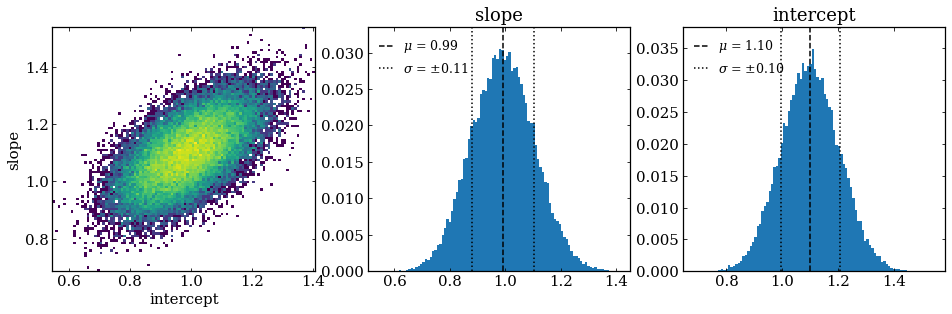

In [7]:
a, ae, b, be = A.mean(), A.std(), B.mean(), B.std()
p_pymc = [a, ae, b, be]

legend_kw = {"frameon" : False,
             "handlelength" : 1.1,
             "fontsize" : 12.5}

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4.5))
ax1.hist2d(A, B, bins=(100,100), norm=LogNorm())
ax1.set_xlabel("intercept")
ax1.set_ylabel("slope")

ax2.set_title("slope")
xA, wA, cA = histogram(A, 100, norm=True)
Amax = max(cA) * 1.1
ax2.bar(xA, cA, wA)
ax2.plot([a,a],[0, Amax], "--k", lw=1.5, label="$\mu$ = {0:.2f}".format(a))
ax2.plot([a+ae,a+ae],[0, Amax], ":k", lw=1.5, label="$\sigma$ = $\pm${0:.2f}".format(ae))
ax2.plot([a-ae,a-ae],[0, Amax], ":k", lw=1.5)
#ax2.set_xlim(0.1, 1.7)
ax2.set_ylim(0, Amax)
ax2.legend(**legend_kw, loc="upper left")

ax3.set_title("intercept")
xB, wB, cB = histogram(B, 100, norm=True)
Bmax = max(cB) * 1.1
ax3.bar(xB, cB, wB)
ax3.plot([b,b],[0, Bmax], "--k", lw=1.5, label="$\mu$ = {0:.2f}".format(b))
ax3.plot([b+be,b+be],[0, Bmax], ":k", lw=1.5, label="$\sigma$ = $\pm${0:.2f}".format(be))
ax3.plot([b-be,b-be],[0, Bmax], ":k", lw=1.5)
ax3.set_ylim(0, Bmax)
ax3.legend(**legend_kw,  loc="upper left");

### **Fitted line**

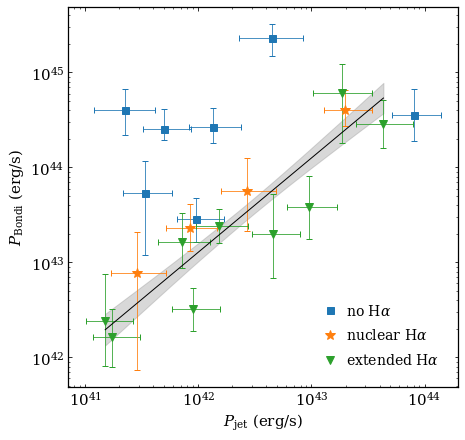

In [8]:
x_fit = np.linspace(min(u[i]), max(u[i]))
y_fit = lambda x: 10**(x[1] + x[2]*x[0])

# plot the data
plot_data()

# plot 1-sigma confidence intervals
realisations = y_fit([x_fit, B[:, None], A[:, None]])
bounds = np.percentile(realisations, 100 * norm.cdf([-1, 1]), axis=0)
plt.fill_between(10**x_fit*c, bounds[0, :]*c, bounds[1, :]*c, color="gray", alpha=0.3)

# plot the line for mean slope and intercept
p2 = plt.plot(10**x_fit*c, y_fit([x_fit, b, a])*c, ls="-", lw=1, marker="", c="k")

## **LINMIX**

Now let's compare the results with a much more sophisticated way of bayesian linear fitting package LINMIX (https://github.com/jmeyers314/linmix).

In [9]:
from linmix import linmix

def fit_linmix(x, y, sig_x, sig_y):
    lm = linmix.LinMix(x, y, xsig=sig_x, ysig=sig_y, nchains=8, seed=42, K=2)
    lm.run_mcmc(silent=True)
    return lm.chain['alpha'], lm.chain['beta'], lm.chain['corr']

In [10]:
# use only Halfa points
i = np.logical_or(Halfa == "NE", Halfa == "E")
X, Xe, Y, Ye = u[i], ue[i], v[i], ve[i]
            
# LINMIX fit
A, B, COR = fit_linmix(X, Y, Xe, Ye)

### **Posterior probability**

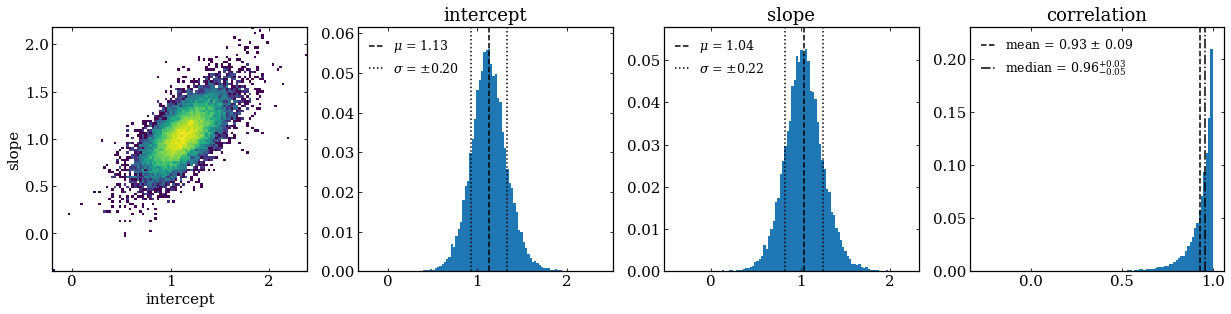

In [11]:
a, ae, b, be = A.mean(), A.std(), B.mean(), B.std()
p_linmix = [b, be, a, ae]
cor, core, cor_med, cor_q25, cor_q75 = COR.mean(), COR.std(), np.median(COR), np.quantile(COR, 0.25), np.quantile(COR, 0.75)
cor_q25, cor_q75 = cor_med - cor_q25, cor_q75 - cor_med

kwargs = {"bins" : 100,
          "ec" : None}

legend_kw = {"frameon" : False,
             "handlelength" : 1.1,
             "fontsize" : 12.5}

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(21,4.5))
ax1.hist2d(A, B, bins=(100,100), norm=LogNorm())
ax1.set_xlabel("intercept")
ax1.set_ylabel("slope")

ax2.set_title("intercept")
xA, wA, cA = histogram(A, 100, norm=True)
Amax = max(cA) * 1.1
ax2.bar(xA, cA, wA)
ax2.plot([a,a],[0, Amax], "--k", lw=1.5, label="$\mu$ = {0:.2f}".format(a))
ax2.plot([a+ae,a+ae],[0, Amax], ":k", lw=1.5, label="$\sigma$ = $\pm${0:.2f}".format(ae))
ax2.plot([a-ae,a-ae],[0, Amax], ":k", lw=1.5)
ax2.set_ylim(0, Amax)
ax2.legend(**legend_kw, loc="upper left")

ax3.set_title("slope")
xB, wB, cB = histogram(B, 100, norm=True)
Bmax = max(cB) * 1.1
ax3.bar(xB, cB, wB)
ax3.plot([b,b],[0, Bmax], "--k", lw=1.5, label="$\mu$ = {0:.2f}".format(b))
ax3.plot([b+be,b+be],[0, Bmax], ":k", lw=1.5, label="$\sigma$ = $\pm${0:.2f}".format(be))
ax3.plot([b-be,b-be],[0, Bmax], ":k", lw=1.5)
ax3.set_ylim(0, Bmax)
ax3.legend(**legend_kw,  loc="upper left");

ax4.set_title("correlation")
xcor, wcor, ccor = histogram(COR, 100, norm=True)
cormax = max(ccor) * 1.1
ax4.bar(xcor, ccor, wcor)
ax4.plot([cor,cor],[0, cormax], "--k", lw=1.5, label="mean = {0:.2f} $\pm$ {1:.2f}".format(cor, core))
ax4.plot([cor_med,cor_med],[0, cormax], "-.k", lw=1.5, label="median = {0:.2f}$_{{-{1:.2f}}}^{{+{2:.2f}}}$".format(cor_med, cor_q25, cor_q75))
ax4.set_ylim(0, cormax)
ax4.legend(**legend_kw);

### **Fitted line**

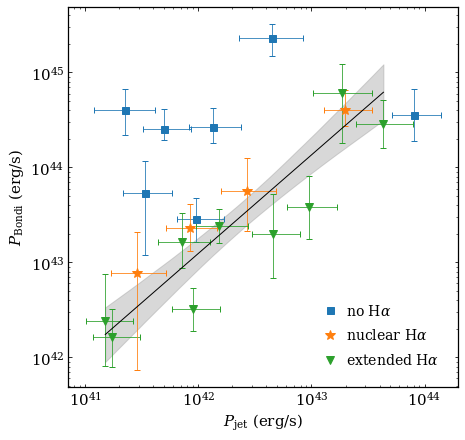

In [12]:
x_fit = np.linspace(min(u[i]), max(u[i]))
y_fit = lambda x: 10**(x[2] + x[1]*x[0])

# plot the data
plot_data()

# plot 1-sigma confidence intervals
realisations = y_fit([x_fit, B[:, None], A[:, None]])
bounds = np.percentile(realisations, 100 * norm.cdf([-1, 1]), axis=0)
plt.fill_between(10**x_fit*c, bounds[0, :]*c, bounds[1, :]*c, color="gray", alpha=0.3)

# plot the line for mean slope and intercept
p2 = plt.plot(10**x_fit*c, y_fit([x_fit, b, a])*c, ls="-", lw=1, marker="", c="k")

### **Results**

The relation between the Bondi power and mechanical jet power can be described by the relation:

$$ \log \frac{P_{\mathrm{Bondi}}}{10^{43} \; \mathrm{erg \, / \, s}} = (1.13 \pm 0.20) + (1.04 \pm 0.22) \cdot \log \frac{P_{\mathrm{jet}}}{10^{43} \; \mathrm{erg \, / \, s}}$$

and the correlation coefficient between the two quantities is $\rho = 0.96$.

## **ODR**

Orthogonal least squares https://docs.scipy.org/doc/scipy/reference/odr.html

In [13]:
from scipy.odr import ODR, RealData, Model

def FIT_ODR(func, X, Y, sig_X, sig_Y, guess, fixed=0):
    data = RealData(X, Y, sx=sig_X, sy=sig_Y)
    model = Model(func)
    if not fixed: fixed = np.ones(len(guess))
    odr = ODR(data, model, beta0=guess, maxit=-1, ifixb=fixed)
    odr.set_job(fit_type=0)
    output = odr.run()
    return output.beta, output.sd_beta

def POW(p, x):
    return p[0] * x**p[1]

In [14]:
i = np.logical_or(Halfa == "NE", Halfa == "E")
odr, odr_e = FIT_ODR(POW, x[i], y[i], xe[i], ye[i], [0,1])
p_odr = [odr[1], odr_e[1], np.log10(odr[0]), np.log10(odr_e[0])]

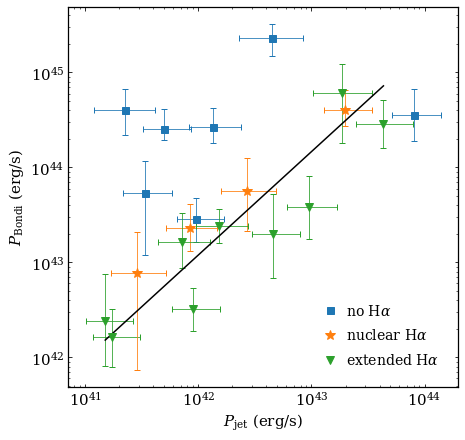

In [15]:
x_fit_ODR = np.linspace(min(x[i]), max(x[i]))

# plot the data
plot_data()

plt.plot(x_fit_ODR*c, POW(odr, x_fit_ODR)*c, "-k", lw=1.5);

## **BCES**

Bivariate Correlated Errors and intrinsic Scatter https://github.com/rsnemmen/BCES

| #  | Method  |  Description |
|---|---| --- |
| 0  | *y\|x*  | Assumes *x* as the independent variable |
| 1  |  *x\|y* | Assumes *y* as the independent variable |
| 2  | bissector  | Line that bisects the *y\|x* and *x\|y*. This approach is self-inconsistent, *do not use this method*, cf. [Hogg, D. et al. 2010, arXiv:1008.4686](http://labs.adsabs.harvard.edu/adsabs/abs/2010arXiv1008.4686H/). |
| 3  | orthogonal  | Orthogonal least squares: line that minimizes orthogonal distances. Should be used when it is not clear which variable should be treated as the independent one |

In [16]:
from bces.bces import bcesp
from nmmn.stats import confband

def fit_bces(x, y, sig_x, sig_y, COV=0, method=0):
    if not COV: COV = np.zeros_like(x)
    a, b, ae, be, covab = bcesp(x, sig_x, y, sig_y, COV)
    return a[method], b[method], ae[method], be[method], covab[method]

In [17]:
i = np.logical_or(Halfa == "NE", Halfa == "E")
b, a, be, ae, cov = fit_bces(u[i], v[i], ue[i], ve[i], method=0)
p_bces = [b, be, a, ae]

func = lambda x: x[1]*x[0]+x[2]
x_fit = np.linspace(min(u[i]), max(u[i]))

covm = np.array([(ae**2, cov), (cov, be**2)])
lcb, ucb, x_conf = confband(u[i], v[i], b, a, 0.68, x_fit)

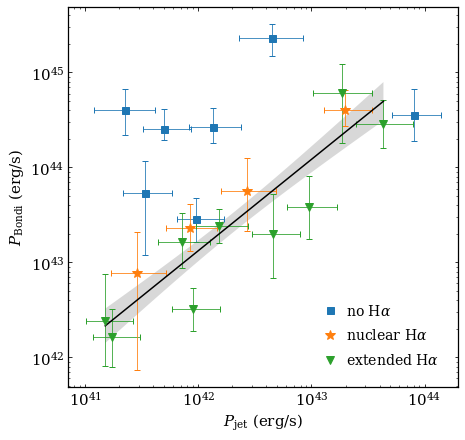

In [18]:
plot_data()
plt.plot(10**x_fit*c, 10**func([x_fit, b, a])*c, "-k", lw=1.5);
plt.fill_between(10**x_fit*c, 10**lcb*c, 10**ucb*c, alpha=0.3, facecolor='gray')

## **Summary**

In [19]:
methods = ["PYMC", "LINMIX", "ODR", "BCES"]
df = pd.DataFrame(index=methods, columns=["intercept", "slope"])

for i, p in enumerate([p_pymc, p_linmix, p_odr, p_bces]):
    df["slope"].loc[methods[i]] = "{0:.2f} +/- {1:.2f}".format(*p[:2])
    df["intercept"].loc[methods[i]] = "{0:.2f} +/- {1:.2f}".format(*p[2:])

df

intercept          slope
PYMC    1.10 +/- 0.10  0.99 +/- 0.11
LINMIX  1.13 +/- 0.20  1.04 +/- 0.22
ODR     1.17 +/- 0.70  1.09 +/- 0.15
BCES    1.09 +/- 0.15  0.96 +/- 0.12

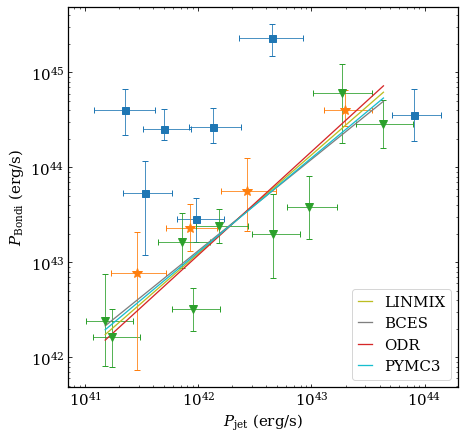

In [20]:
plot_data()

kwargs = {"lw" : 1.3,
          "ls" : "-",
          "marker" : ""}

plt.plot(10**x_fit*c, y_fit([x_fit, p_linmix[0], p_linmix[2]])*c, **kwargs, c="C8", label="LINMIX")

plt.plot(10**x_fit*c, y_fit([x_fit, p_bces[0], p_bces[2]])*c, **kwargs, c="C7", label="BCES");

plt.plot(x_fit_ODR*c, POW(odr, x_fit_ODR)*c, **kwargs, c="C3", label="ODR");

plt.plot(10**x_fit*c, y_fit([x_fit, p_pymc[0], p_pymc[2]])*c, **kwargs, c="C9", label="PYMC3")

plt.legend(handlelength=0.9);